<a href="https://colab.research.google.com/github/vatsal-create/ARTISTIC_IMAGE_GENERATOR/blob/main/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**PREPARE AN IMAGE IN THE STYLE OF ANOTHER IMAGE USING NEURAL STYLE TRANSFER**

This project is based on the concept of Neural Style Transfer in Deep Learning.This notebook is to drive us through the intricacies of the same. 

For this purpose I have used the prebuilt CNN image classification model VGG19, runner up of the ILSVRC-2014 competition and modeified it a little to serve as the base model for my project.Using prebuilt model is essential because they are pre-trained against a number of instances.

**LINKING GOOGLE DRIVE TO GOOGLE COLAB**

Using prebuild code snippets provided in the colab environment , I linked my google drive to this notebook.Drive serves as the source of all the stored data for this project

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORTING THE REQUIRED MODULES FOR THIS PROJECT**


In [4]:
import tensorflow as tf
import numpy as np
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display
import cv2
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

Function to convert Javascript object into an OpenCv image 


In [5]:
def js_to_image(js_obj):
  image_bytes=b64decode(js_obj.split(',')[1])
  arr=np.frombuffer(image_bytes,dtype=np.uint8)
  img=cv2.imdecode(arr,flags=1)
  return img

**IMPORTING DEPENDENCIES IN GOOGLE COLAB TO ACCESS THE WEBCAM**

Accessing webcams in google Colab is a bit trikcy!, this is because the Cloud server to which this notebook is connected does not have a webcam, we have to use some Javascript magic to drive it to the location of our system's webcam. This is done by simply inserting the prebuilt code snippet for camera capture provided on the left pane of this notebook. I have modified it a little to suit my needs


In [6]:
def take_photo(filename='photo.jpg', quality=0.8):
  filename='/content/drive/MyDrive/Colab Notebooks/'+filename
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)


  #MODIFICATION STARTS
  data = eval_js('takePhoto({})'.format(quality)) #saves photo data in the form of JS object
  #binary = b64decode(data.split(',')[1])

  img=js_to_image(data) # passing the image data object to the prebuilt function to get an OPENCV image object
  cv2.imwrite(filename,img) #saving the image to the given filename using OPENCV's imwrite function

  return filename #returns the full filename of the saved image, good for the easy refernce of the calling function

**DECLARING SOME GLOBAL VARIABLES**

In [7]:
content_path='/content/drive/MyDrive/Colab Notebooks/image.jpg' #initial content path for my image
style_path='/content/drive/MyDrive/Colab Notebooks/' # path to the folder containing the style images for my project
filename=None # will later store the loaction of the content image, entered by the user
style_img_filename=None 

**IMPORTING PRE BUILT VGG19 NETWORK USING KERAS**

In this cell, I have imported the pre-trained VGG19 image classification model and set it to be non trainable.I have excluded the top because we dont need the flatten and classification layers in this project, we only need the Convolutional and Pooling layers

In [8]:
vgg=vgg19.VGG19(weights='imagenet',include_top=False) #storing the pre built model by the name of vgg
vgg.trainable=False #important step as it sets the model to be non trainable, so that we don't modif the weights at any stage
print(vgg.summary()) #prints the summary of the model

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

**CELL TO RETURN A MODEL FOR OUR NETWORK**

We don't need the entire VGG19 model for the purpose of solving this project, the user decides the layers he/she wants to choose as being the part of the model. We require only one layer to calulate the content loss and not more the 5 for calculating the style loss. These layers are stored in content_layer and style_layers variables respectively

In [9]:
def get_model(content_layer,style_layers):
  content_out=[vgg.get_layer(layer).output for layer in content_layer] #stores the output of the content layer
  style_out=[vgg.get_layer(layer).output for layer in style_layers] #stores the output of the style layers
  model_out=style_out+content_out #resulting combination of the two makes the model output
  model=models.Model(vgg.input,model_out) # defining the model with the required inputs and outputs
  return model #returning the prepared model

**LOADING AND PREPROCESSING THE IMAGE**

Below cell is used to load and then return the preprocessed image to the calling function. I have used the PIL for this purpose and a few built-in functions.

In [10]:
def load_and_preprocess(img_path):
  
  image=Image.open(img_path) #using PIL to open and save the image stored at img_path
  max_dim=512 #defines the maximum dimension of the loaded image
  scale=max_dim/max(image.size) 
  img=image.resize((round(image.size[0]*scale),round(image.size[1]*scale)),Image.ANTIALIAS) #resize the image so that the larger dimension becomes equal to 512

  img_arr=process_im.img_to_array(img) #converting the raw image to image array of np type
  img_arr=np.expand_dims(img_arr,axis=0) 

  img=vgg19.preprocess_input(img_arr) #passing the image array to the pre built preprocess_input function so that the image is ready for VGG19 

  return img #returns the preprocessed image

**DEPROCESSING**

Similar to preprocesing , once the task is finished, we need to deprocess the input image so that it returns to its original form and becomes ready for re-use

In [11]:
def deprocess_img(processed_img):
  x=processed_img
  if(len(x.shape)==4):
    x=np.squeeze(x,axis=0)
  assert len(x.shape)==3

  x[:,:,0]+=103.939
  x[:,:,1]+=116.779
  x[:,:,2]+=123.68
  x=x[:,:,::-1]
  x=np.clip(x,0,255).astype('uint8')
  return x


**ALL THE LOSS FUNCTIONS UNDER ONE CELL**

This cell is used to calculate all the required loss functions for the purpose of this task. Content loss function is used to find the difference between the activations of the generated matrix and the content matrix at a particular(given) layer. 

Style loss function calculates the L2 norm distance between the gram matrices of the generated image and the style image at a number of layers(given to the function). Gram matrices are used to represent the style of an image. 

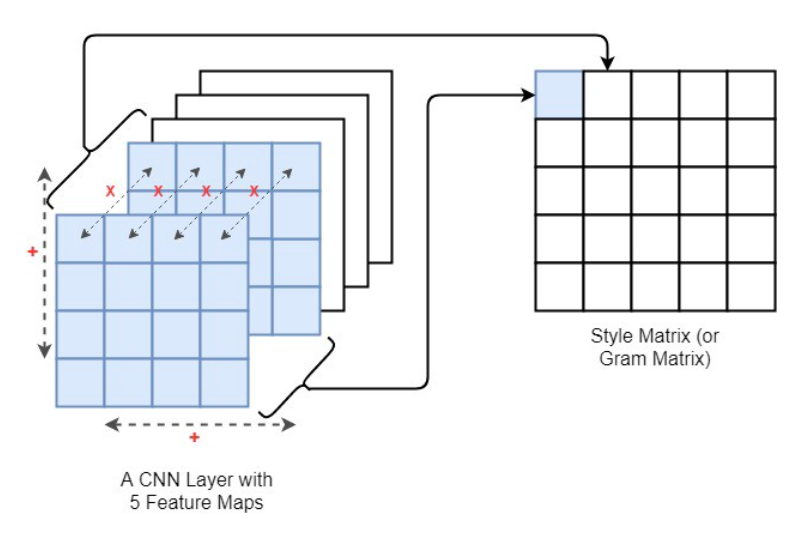



In [24]:
def get_content_loss(noise,target):
  loss=0.5*tf.reduce_sum(tf.square(noise-target)) 
  return loss

def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise) #gets the gram matrix for the input image
    #gram_target=gram_matrix(target)
    #loss=tf.reduce_mean(tf.square(target-gram_noise))
    loss=0.2*tf.reduce_sum(tf.square(target-gram_noise)) #once we get the gram matrices, style loss for that particular layer can be easily calculated
    return loss

def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image) #the output if we fetch in the random noise image to the model created above
    content_loss=0 
    style_loss=0
    
    noise_style_features = output[:5]
    noise_content_feature = output[5:]
    
    w=1/5.0
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=w*get_style_loss(b[0],a) 
        
    
    content_loss=get_content_loss(noise_content_feature[0],content_features)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    return total_loss,style_loss,content_loss

def gram_matrix(feature): #function to return the calculated gram matrix of the input image
    channels=int(feature.shape[-1]) 
    feature=tf.reshape(feature,[-1,channels])
    n=tf.shape(feature)[0]
    gram_matrix=tf.matmul(feature,feature,transpose_a=True) #matrix multiplication of the features with its transpose
    return gram_matrix/tf.cast(n,tf.float32) 

**THE BELOW CELL CALCULATES THE GRADIENTS**


In [13]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss
    

**CELL TO RETURN THE FEATURES FOR CONTENT AND STYLE IMAGES**

The below cell is used to return the features obtained when we pass our content and style images to the model prepared above

In [14]:
def features(model,content_path,style_path):
  content_img=load_and_preprocess(content_path) #get the conetent_img from the content_path
  style_img=load_and_preprocess(style_path) #get the style_img from the style_path

  content_out=model(content_img) #providing the content image as input to the model and gathering its output
  style_out=model(style_img) #providing the style image as an input to the model and gathering its output

  content_feature=[layer[0] for layer in content_out[5:]]
  style_feature=[layer[0] for layer in style_out[:5]]
  
  return content_feature,style_feature

**FUNCTION TO ACTUALLY RUN STYLE TRANSFER AND COORDINATE AMONG OTHER FUNCTIONS**

The below cell defines the main function used to run style transfer, this fuction takes in the image paths and the weightage of style and content images and returns us the best possible generated image

In [16]:
def run_style_transfer(content_path,style_path,epochs=500,content_wt=1000,style_wt=10):

  content_layer=['block5_conv2'] # The layer used to calculate content loss from

  style_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1'] # The layers to be used to calculate the style loss

  model=get_model(content_layer,style_layers) 

  for layer in model.layers:
    layer.trainable=False # the model layers have to be non trainable so that differnt executions do not produce different outputs
  
  content_feature,style_features=features(model,content_path,style_path)

  style_gram_matrix=[gram_matrix(feature) for feature in style_features]

  noise = load_and_preprocess(content_path) #we initialise our noise matrix to be equal to the content image, primarilay so that the transition is faster and the resulting image is of the sam size as that of the contecnt image
  noise=tf.Variable(noise,dtype=tf.float32)

  optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1) #defining Adam optimizer for optimizing
  best_loss=float('inf')
  best_img=None

  loss_weights=(style_wt,content_wt)

  dictionary={'model':model,'loss_weights':loss_weights,'image':noise,'gram_style_features':style_gram_matrix,'content_features':content_feature}

  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means 

  for i in range(epochs):
    grad,all_loss=compute_grads(dictionary)
    total_loss,style_loss,content_loss=all_loss
    optimizer.apply_gradients([(grad,noise)])
    clipped=tf.clip_by_value(noise,min_vals,max_vals)
    noise.assign(clipped)
        
    if total_loss<best_loss:
      best_loss = total_loss
      best_img = deprocess_img(noise.numpy())

    if i%10==0:
      img = noise.numpy()
      img = deprocess_img(img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(img))
      print('Epoch: {}'.format(i))        
      
  IPython.display.clear_output(wait=True)

  x='/content/drive/MyDrive/Colab Notebooks/' 
  x+=style_img_filename
  I=cv2.cvtColor(best_img,cv2.COLOR_RGB2BGR) #converting RGB to BGR because of different comaptaibilities of PIL and OPENCV
  cv2.imwrite(x,I) #saving the image into the file path provided
    
  return best_img,best_loss

CELL TO DISPLAY ALL THE AVAILABLE STYLES

Text(0.5, 1.0, '5')

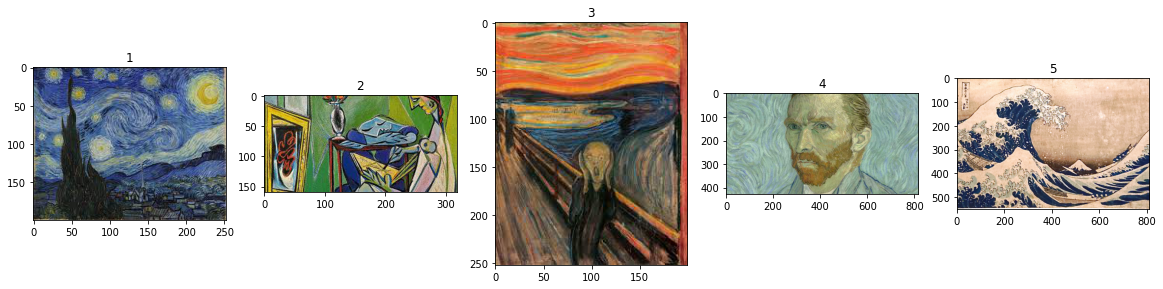

In [17]:
plt.figure(figsize=(20,20))
plt.subplot(1,5,1)
i=style_path+'1.jpg'
i=Image.open(i)
plt.title('1')
plt.imshow(i)

plt.subplot(1,5,2)
i=style_path+'2.jpg'
i=Image.open(i)
plt.imshow(i)
plt.title("2")

plt.subplot(1,5,3)
i=style_path+'3.jpg'
i=Image.open(i)
plt.imshow(i)
plt.title("3")

plt.subplot(1,5,4)
i=style_path+'4.jpg'
i=Image.open(i)
plt.imshow(i)
plt.title("4")

plt.subplot(1,5,5)
i=style_path+'5.jpg'
i=Image.open(i)
plt.imshow(i)
plt.title("5")

**THE MAIN PART OF OUR CODE**

This cell executes neural style transfer as long as the user wants. The user has option to both provide content image from webcam or use a pre loaded image as one.

Resulting image saved successfully!!!
Do you want to continue?(Y/N)N


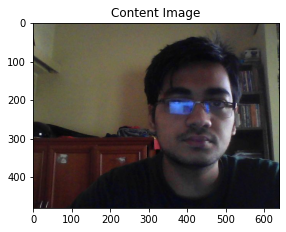

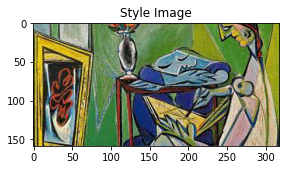

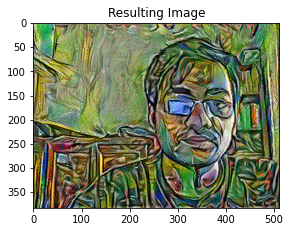

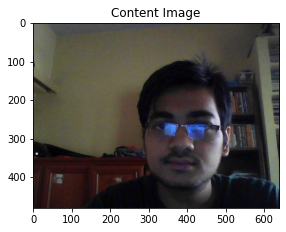

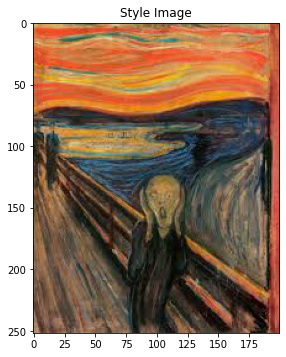

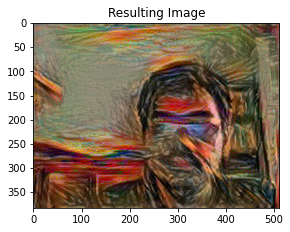

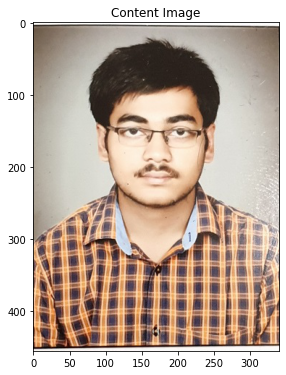

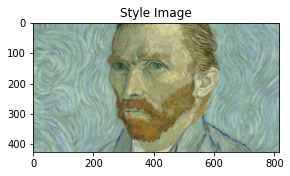

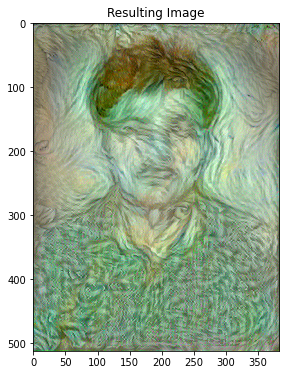

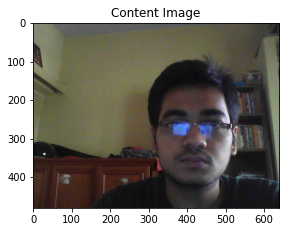

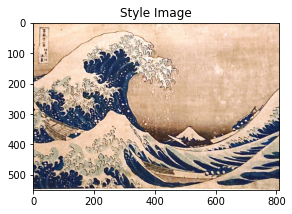

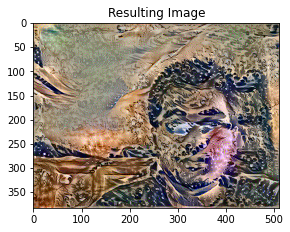

In [26]:
more=True
while(more):
  style_path='/content/drive/MyDrive/Colab Notebooks/'
  n=input("Choose the desired style of your image(enter its number)") #getting the choice of the user
  style_path+=n+'.jpg'

  i=input("Using webcamera to give content image?(Y/N)")
  if(i=='Y'):
    filename=input("Enter the image name you desire to save the content image as")
    print("Click capture when ready!!")
    filename=take_photo(filename)
  else: #if webcam is not to be used the user has to provide the content image path
    filename=input("Enter the full file path of the content image")
  
  style_img_filename=input("Enter the filename you desire to save ur resulting img as")
  best,best_loss=run_style_transfer(filename,style_path,600,100,100)
  print("Resulting image saved successfully!!!")

  plt.figure(figsize=(15,15))
  plt.subplot(1,3,3)
  i=Image.open(filename)
  plt.title("Content Image")
  plt.imshow(i)

  plt.figure(figsize=(15,15))
  plt.subplot(1,3,2)
  i=Image.open(style_path)
  plt.title("Style Image")
  plt.imshow(i)

  plt.figure(figsize=(15,15))
  plt.subplot(1,3,1)
  plt.title("Resulting Image")
  plt.imshow(best)

  ans=input("Do you want to continue?(Y/N)")
  if ans=='Y':
    more=True
  else:
    more=False